In [67]:
from __future__ import division, print_function, absolute_import
import numpy as np
from numpy import sqrt, pi, cos, sin, log, exp, sinh
from phidl import Device, Layer, LayerSet, device_layout, Path, CrossSection, Device
from phidl import quickplot as qp
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu
import phidl.path as pp
from phidl import quickplot as qp
import bezier
import math
import sys
import os
import math
sys.path.append(os.path.abspath(r"/Users/kamilakunes/Desktop/MJLab/Chunho_lib_240919"))
from Chunho_lib_111723_airsuspended import *
from Chunho_lib_111723_electrodes import *
from Chunho_lib_111723_heaters import *
from Chunho_lib_111723_markers import *
from Chunho_lib_111723_waveguides import *
from Chunho_lib_111723_greyscale import *

In [68]:
ls = LayerSet() # Create a blank LayerSet
ls.add_layer(name = 'label', gds_layer = 1, gds_datatype = 0,
             description = 'General label', color = 'deeppink')
ls.add_layer(name = 'marker', gds_layer = 2, gds_datatype = 0,
             description = 'EBL marker', color = 'firebrick')
ls.add_layer(name = 'grating', gds_layer = 3, gds_datatype = 0,
             description = 'bragg_grating', color = 'darkturquoise')
ls.add_layer(name = 'wg', gds_layer = 4, gds_datatype = 0,
             description = 'LN wg', color = 'dodgerblue')
ls.add_layer(name = 'ring', gds_layer = 5, gds_datatype = 0,
             description = 'LN ring', color = 'deepskyblue')
ls.add_layer(name = 'gold1', gds_layer = 6, gds_datatype = 0,
             description = 'Gold electrode', color = 'gold')
ls.add_layer(name = 'via', gds_layer = 7, gds_datatype = 0,
             description = 'hole', color = 'grey')
ls.add_layer(name = 'gold2', gds_layer = 8, gds_datatype = 0,
             description = '2nd Gold electrode', color = 'goldenrod')
ls.add_layer(name = 'nicr', gds_layer = 9, gds_datatype = 0,
             description = 'heater', color = (0.4,0.5,0.7))
ls.add_layer(name = 'test', gds_layer = 10, gds_datatype = 0,
             description = 'alignment', color = 'lime')
ls.add_layer(name = 'mc', gds_layer = 11, gds_datatype = 0,
             description = 'mode converter', color = 'mediumblue')
ls.add_layer(name = 'detch', gds_layer = 12, gds_datatype = 0,
             description = 'deep etch', color = 'orangered')
ls.add_layer(name = 'pcm', gds_layer = 13, gds_datatype = 0,
             description = 'pcm', color = 'orangered')

pu.write_lyp('my_layer_properties_file.lyp', layerset = ls)

layer_label =  ls['label']
layer_marker = ls['marker']
layer_grating = ls['grating']
layer_wg = ls['wg']
layer_ring = ls['ring']
layer_metal = ls['gold1']
layer_via = ls['via']
layer_metal2 = ls['gold2']
layer_heater = ls['nicr']
layer_test = ls['test']
layer_MC = ls['mc']
layer_Detch = ls['detch']
layer_pcm = ls['pcm']

In [69]:
# parameters
radius_wg = 100
wg_single = 0.8
wg_dc_bus=1
wg_pulley_bus=0.8
wg_mod = 2.0
taperlength1 = 100 #General tapering

# stuff i guess i need
facet_width1=3
pad_w=150
signal_body_w=50
gap_body1=3.7
edge_width1=6.5
edge_width2=0.5
gap_body2=gap_body1+(edge_width1+edge_width2)*2
mod_l = 50
y_splitter_length=200
y_splitter_output_length = 50


Tring_wgcp1 = np.array([
    [0.7 for x in range(1)],
    [0.8 for x in range(1)],
    [0.9 for x in range(1)],
    [0.95 for x in range(1)],
    [1.0 for x in range(1)],
    [1.1 for x in range(1)]]
)


D = Device()


In [70]:
# Adjustable parameters
ws = 30 # waveguide spacing to avoid interctions (um)
mrow = 6
mcol = 4

#Facet parameters
facet_length=1000
facet_width=3


In [71]:
def straight(width=3, layer = layer_wg, length=100):
        D = Device()
        D << Path().append(pp.straight(length=length)).extrude(width, layer)
        D.add_port(name = "o1", midpoint = [0,0], width = width, orientation = -180)
        D.add_port(name = "o2", midpoint = [length, 0], width = width, orientation = 0)
        return D

def taper(length=200, width1=3, width2=5, layer=layer_wg):
        D = Device()
        t = D << pg.taper(length=length, width1=width1, width2=width2, layer=layer)
        D.add_port(name = "o1", port=t.ports[1])
        D.add_port(name = "o2", port=t.ports[2])
        return D

def facet(device, port, angle, vertical_offset, waveguide_length):
        D = Device()
        # Retrieve the starting point and orientation from the existing device's port
        start_in_port = device.ports[port]
        x1, y1 = start_in_port.midpoint  # Starting point (x1, y1)

        # Calculate the new waveguide's position based on the vertical offset
        pos_x = x1  # Keep the x-position the same as the port's x
        pos_y = vertical_offset  # Offset the y-position

        # Create the new waveguide (not connected to the port)
        f = D << straight(width=facet_width, layer = layer_wg, length=waveguide_length)
        # facet_ref = D.add_ref(f)
        D.rotate(angle=angle)
        D.move((pos_x, pos_y))
        
        D.add_port(name = "f1", port=f.ports["o1"])
        D.add_port(name = "f2", port=f.ports["o2"])
        return D


def connect_with_taper(dev1, port1, dev2, port2, layer=layer_wg):

    D = Device()

    port_1 = dev1.ports[port1]
    port_2 = dev2.ports[port2]

    # Calculate taper parameters based on the ports
    start_width = port_1.width
    
    end_width = port_2.width

    # Calculate the distance between the two ports
    x1, y1 = port_1.midpoint
    x2, y2 = port_2.midpoint
    taper_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Create the taper geometry
    taper = pg.taper(length=taper_length, width1=start_width, width2=end_width, layer=layer)

    # Add the taper to the device
    taper_ref = D.add_ref(taper)

    # Align the taper: first align it with port1
    taper_ref.connect(1, destination=port_1)

    taper_ref.move(origin=taper_ref.ports[2].midpoint, destination=port_2.midpoint)

    # Add ports to the new device to preserve connectivity
    D.add_port(name="tc1", port=taper_ref.ports[1])
    D.add_port(name="tc2", port=taper_ref.ports[2])

    return D

def taper_connect(device1, port1, device2, port2):
        D = Device()
        tc = D << pg.taper(length=length, width1=width1, width2=width2, layer=layer)
        D.add_port(name = "o1", port=tc.ports[1])
        D.add_port(name = "o2", port=tc.ports[2])
        return D

In [72]:
left_turn1 = pp.euler(radius = radius_wg, angle = 90, p = 0.5, use_eff = True, num_pts = 10000)
right_turn1 = pp.euler(radius = radius_wg, angle = -90, p = 0.5, use_eff = True, num_pts = 10000)
cross_section_multi= CrossSection().add(width = wg_mod, offset = 0, name = 'wg', layer = layer_wg, ports = ['1','2'])
Taperpath1= pp.straight(length = (taperlength1))
cross_section_single = CrossSection().add(width = wg_pulley_bus, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])
PositiveTaper1 = pp.transition(cross_section1 = cross_section_single, cross_section2 = cross_section_multi, width_type = 'linear')
NegativeTaper1 = pp.transition(cross_section1 = cross_section_multi, cross_section2 = cross_section_single, width_type = 'linear')

cross_section_facet = CrossSection().add(width = facet_width1, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])
NegativeTaper_facet = Cross_ArbTaper(wg_input=facet_width1,wg_output=wg_pulley_bus,offset=0,layer=layer_wg)
PositiveTaper_facet = Cross_ArbTaper(wg_input=wg_pulley_bus,wg_output=facet_width1,offset=0,layer=layer_wg)

In [73]:


def Y_AsymAM():
                D = Device()
                # AM 
                AMWG1= D.add_ref(Mod_WG(wg_width= wg_mod,pad_w=pad_w,signal_body_w=signal_body_w,gap_body=gap_body2,pad_l = 0,
                                        taper_l = 0,mod_l = mod_l,layer=layer_wg))
                

                top_arm = 100 # added height to the top arm of the MZI
                bot_arm = 0 # added height to the bottom arm of the MZI

                #AM asymmetric turns path           
                AM_armtop_turn1 = D.add_ref(Path().append([
                left_turn1, pp.straight(length = top_arm/2), right_turn1, right_turn1, pp.straight(length = top_arm/2), left_turn1
                ]).extrude(cross_section_multi)).connect('2', AMWG1.ports['lt'])

                AM_armbot_turn1 = D.add_ref(Path().append([
                right_turn1, pp.straight(length = bot_arm/2), left_turn1, left_turn1, pp.straight(length = bot_arm/2), right_turn1
                ]).extrude(cross_section_multi)).connect('2', AMWG1.ports['lb'])

                # Defining tapers extruding turns
                AM_armtop_input1= D.add_ref(Path().append([Taperpath1]).extrude( PositiveTaper1)).connect('2', AM_armtop_turn1.ports['1']) # connect using top of mzi positive taper correct for l_splitter top
                AM_armbot_input1= D.add_ref(Path().append([Taperpath1]).extrude( PositiveTaper1)).connect('2', AM_armbot_turn1.ports['1']) # connect using bot of mzi
                
                AM_armtop_output1= D.add_ref(Path().append([Taperpath1]).extrude( NegativeTaper1)).connect('1', AMWG1.ports['rt'])
                AM_armbot_output1= D.add_ref(Path().append([Taperpath1]).extrude( NegativeTaper1)).connect('1', AMWG1.ports['rb'])
                
                
                Ysplit_l=D.add_ref(Ysplitter_left(wg_width1=wg_single,
                                                    splitter_length=y_splitter_length,
                                                    modulator_pitch=gap_body2+signal_body_w,
                                                    layer=layer_wg
                                                )).connect(port = 'out1', destination = AM_armtop_input1.ports['1']).move([0, 0])

                Ysplit_r=D.add_ref(Ysplitter_right(wg_width1=wg_single,
                                                    splitter_length=y_splitter_length,
                                                    modulator_pitch=gap_body2+signal_body_w,
                                                    layer=layer_wg
                                                )).connect(port = 'in1', destination = AM_armtop_output1.ports['2']).move([0, 0])
                
                # Adding turns

                AM_arm_input2= D.add_ref(Path().append([
                Taperpath1
                ]).extrude(NegativeTaper1)).connect('2', Ysplit_l.ports['in1'])

                AM_arm_input3= D.add_ref(Path().append([
                left_turn1
                ]).extrude(cross_section_multi)).connect('2', AM_arm_input2.ports['1'])

                AM_arm_input4= D.add_ref(Path().append([
                Taperpath1
                ]).extrude(PositiveTaper1)).connect('2', AM_arm_input3.ports['1'])


                AM_arm_output2= D.add_ref(Path().append([
                Taperpath1
                ]).extrude(PositiveTaper1)).connect('1', Ysplit_r.ports['out1'])

                AM_arm_output3= D.add_ref(Path().append([
                right_turn1
                ]).extrude(cross_section_multi)).connect('1', AM_arm_output2.ports['2'])

                AM_arm_output4= D.add_ref(Path().append([
                Taperpath1
                ]).extrude(PositiveTaper1)).connect('1', AM_arm_output3.ports['2'])
            
                # text0 = 'AsymYMZI-Dev ' + str(round(ii+1, 4)) + ', ' + str(round(jj+1, 4))
                # text1 = 'Electrode gap' + str(round(gap_body1, 4))+'H' + str(round(edge_width1, 4))
                # text2 = 'Asympath ' + str(round(turn_length1, 4))+'& WGwidth ' + str(round(wg_mod, 4))
                # text3 = '^'

                # label0 = D.add_ref(pg.text(text0, size = 15, justify = 'center', layer = layer_label))
                # label0.center = [AMWG1.xmin-600, AMWG1.ymax +200] # center the red label
                # label1 = D.add_ref(pg.text(text1, size = 15, justify = 'center', layer = layer_label))
                # label1.center = [label0.center[0], label0.center[1] -30]
                # label2 = D.add_ref(pg.text(text2, size = 15, justify = 'center', layer = layer_label))
                # label2.center = [label0.center[0], label1.center[1] -30]
               
                # label7 = D.add_ref(pg.text(text3, size = 15, justify = 'center', layer = layer_label))
                # label7.center = [AMSegElec1.xmin, AMSegElec1.ymin-20]
                # label8 = D.add_ref(pg.text(text3, size = 15, justify = 'center', layer = layer_label))
                # label8.center = [AMSegElec1.xmax, AMSegElec1.ymin-20]

                D.add_port(name='in1', port =  AM_arm_input4.ports['1']) # label input and output ports
                D.add_port(name='out1', port = AM_arm_output4.ports['2'])
                
                ################################### Adding input/output turns for MZI



                # D.add_port(name='MZIin', port =  Ysplit_l.ports['in1']) # label input and output ports
                # D.add_port(name='MZIout', port = Ysplit_r.ports['out1'])

                D.center=[0,0]

                D.add_ref(marker1(center = (-23,0), arm_length = 40, arm_width = 5, layer = layer_marker))
                
            
                return D

Device width: 1452.0
Device length: 519.6999999999999


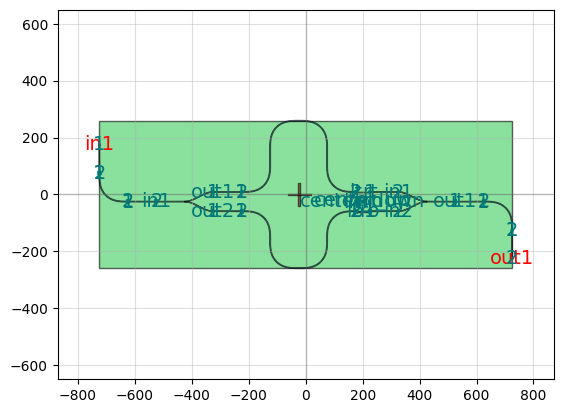

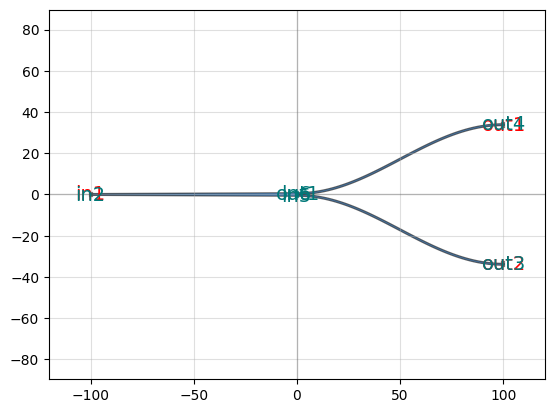

In [74]:
# Provides width and length of a device

J = Y_AsymAM()
bbox = J.bbox

# Calculate the width and length of the device
D_width = bbox[1][0] - bbox[0][0]  # x2 - x1
D_length = bbox[1][1] - bbox[0][1]  # y2 - y1

# Print the size of the device
print(f"Device width: {D_width}")
print(f"Device length: {D_length}")

# Add a rectangle representing the bounding box
bbox_rect = J << pg.rectangle(size=(bbox[1][0] - bbox[0][0], bbox[1][1] - bbox[0][1]))
bbox_rect.move([bbox[0][0], bbox[0][1]])  # Move bbox rectangle to the correct position


qp(J)

P = Ysplitter_left(wg_width1=wg_single, splitter_length=y_splitter_length, modulator_pitch=gap_body2+signal_body_w,layer=layer_wg)
qp(P)

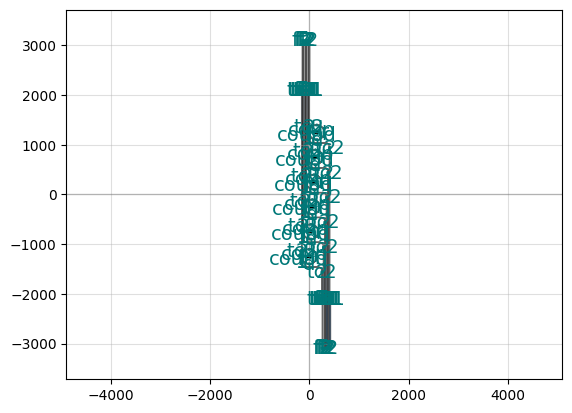

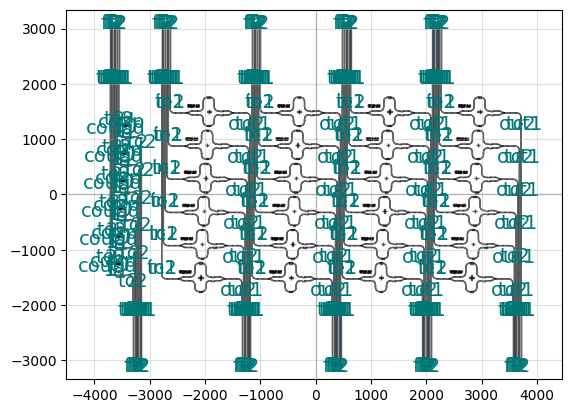

In [75]:
# Function to create a 4x4 matrix of Y_AsymAM devices
# dev_pitch_x = 4*500
# dev_pitch_y = 1*500



def create_chip_matrix(row,col):
    # Initialize the main device
    D = Device('Y_AsymAM_Chip')

    dev_pitch_x = D_width+(ws*row)  # Horizontal spacing
    dev_pitch_y = D_length+ws+50  # Vertical spacing
    
    ######################### Facet variables
    facet_y_pos = ((row*dev_pitch_y)/2 + 300)
    offset1 = 0
  
    # Loop to create a nxm matrix of Y_AsymAM devices
    for m in range(col+1):

        if m == 0:
            #testrings
            Tring_radius=150
            Tring_bend_radius=100
            Tring_wg_single=0.8
            Tring_wg_ring1=1.2
            Tring_wg_ring2=1.6
            Tring_step=30
            Tring_step2=65
            Tring_dev_pitch_y2=500
            Tring_width = 412
            Tring_xoffset1=0
            Hpath1 = 210

            num_l=6
            ll=0
            for ll in range(0,num_l):
                

                    #Test rings
                    ring1 = D.add_ref(ring_circle(radius = Tring_radius, width = Tring_wg_ring1, angle_resolution = 0.5, layer = layer_ring))
                    ring1.move([Tring_step*(ll)+Tring_xoffset1, (-(num_l - 1)/2+ll)*Tring_dev_pitch_y2])

                    left_turn2 = pp.euler(radius = Tring_bend_radius, angle = 90, p = 0.5, use_eff = True)
                    right_turn2 = pp.euler(radius = Tring_bend_radius, angle = -90, p = 0.5, use_eff = True)
                    cross_section_single = CrossSection().add(width = Tring_wg_single, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])

                    coupler1 = D.add_ref(coupler_straight(width = Tring_wg_single, length = Tring_radius*1.5, layer = layer_wg)).connect(port = 'coup', destination = ring1.ports['l']).move([-Tring_wgcp1[ll,0],0])
                    cross_section_single2 = CrossSection().add(width = facet_width1, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])

                    wg_dev_out = D.add_ref(Path().append([
                            left_turn2, 
                            pp.straight(length = Hpath1),
                            right_turn2,
                            ]).extrude(cross_section_single)).connect('1', coupler1.ports['1'])
                    
                    facet_top = facet(coupler1, '2', 90, facet_y_pos, facet_length)
                    facet_bot = facet(wg_dev_out, '2', -90, -facet_y_pos, facet_length)

                    tap_top = connect_with_taper(facet_top,'f1', coupler1,'2', layer=layer_wg)
                    tap_bot = connect_with_taper(facet_bot,'f1', wg_dev_out,'2', layer=layer_wg)
                    
                    #Text
                    text0 = 'TRing ' + str(round(m+1, 4)) + ', ' + str(round(ll+1, 4))
                    text3 = 'wgcp ' + str(round(Tring_wgcp1[ll,0], 4)) + ' , radius ' + str(round(Tring_radius, 4))
                    text4 = 'BWidth ' + str(round(Tring_wg_single, 4)) + ' , RWidth' + str(round(Tring_wg_ring1, 4))

                    label_ring0 = D.add_ref(pg.text(text0, size = 7, justify = 'center', layer = layer_label))
                    label_ring0.center = [ring1.center[0], ring1.center[1] + 30]
                    label_ring1 = D.add_ref(pg.text(text3, size = 7, justify = 'center', layer = layer_label))
                    label_ring1.center = [label_ring0.center[0], label_ring0.center[1] -20]
                    label_ring2 = D.add_ref(pg.text(text4, size = 7, justify = 'center', layer = layer_label))
                    label_ring2.center = [label_ring0.center[0], label_ring0.center[1] -40]

                    D.add_ref(facet_top) # Coupler top facet
                    
                    D.add_ref(facet_bot) # Coupler bottom facet
                    D.add_ref(tap_top)
                    D.add_ref(tap_bot) # Coupler top facet

            

            # Get the bounding box of the device
            bbox = D.bbox
            # Calculate the width and length of the device
            offset1 = 3*500 #bbox[1][0] - bbox[0][0] + D_width + ws*mrow # x2 - x1

            qp(D)
        
        else:
            for n in range(row):

                Mod1 = Y_AsymAM()

                pcm_top = pg.rectangle(size=(50, 20), layer = layer_pcm)
                pcm_top.move([-50, 250])  # Move bbox rectangle to the correct position
                Mod1.add_ref(pcm_top)

                pcm_bot = pg.rectangle(size=(50, 20), layer = layer_pcm)
                pcm_bot.move([-50, -267])  # Move bbox rectangle to the correct position
                Mod1.add_ref(pcm_bot)
                

# # Position the device in the grid
#             step_x = (-(4 - 1)/2 + ii) * dev_pitch_i + ws*jj
#             # print(step_x)
#             step_y = (-(4 - 1)/2 + jj) * dev_pitch_j
#             Mod1.move([step_x, step_y])  # Move the device to its position in the grid

                # Position the device in the grid
                # stagger = (-1)**(n) * 200
                step_x = offset1 + (m-1) * dev_pitch_x + ws*n

                step_y = (-(row - 1)/2 + n) * dev_pitch_y
                Mod1.move([step_x, step_y])  # Move the device to its position in the grid

                D.add_ref(Mod1)


                
                # Mod1 = D.add_ref(Y_AsymAM())  # Add the MMI AsymAM device to the chip
                
                # # Position the device in the grid
                # stagger = (-1)**(n) * 200
                # step_x = offset1 + (m-1) * dev_pitch_x + stagger

                # step_y = (-(row - 1)/2 + n) * dev_pitch_y
                # Mod1.move([step_x, step_y])  # Move the device to its position in the grid

                ######################### LABEL DEVICES

                dev_label = f"PCM MZI Dev - ({(-n+row)} , {m}) \n PCM Length - 50 um"
                label_dev = D.add_ref(pg.text(dev_label, size = 15, justify = 'center', layer = layer_label))
                label_dev.center = [step_x-300, step_y+100]

                ################################### Adding input/output turns for MZI
                
                # y_output_len_left = 10 #+ (row-(row%2+1)-n)*30 + stagger +200
                # y_output_path_left= pp.straight(length = (y_output_len_left))

                # AM_arm_input2= D.add_ref(Path().append([
                # y_output_path_left
                # ]).extrude(NegativeTaper1)).connect('2', Mod1.ports['MZIin'])

                # AM_arm_input3= D.add_ref(Path().append([
                # left_turn1
                # ]).extrude(cross_section_multi)).connect('2', AM_arm_input2.ports['1'])

                # AM_arm_input4= D.add_ref(Path().append([
                # Taperpath1
                # ]).extrude(PositiveTaper1)).connect('2', AM_arm_input3.ports['1'])


                # y_output_len_right = 10 #+ 30*(n) - stagger + 200
                # y_output_path_right= pp.straight(length = (y_output_len_right))

                # AM_arm_output2= D.add_ref(Path().append([
                # y_output_path_right
                # ]).extrude(PositiveTaper1)).connect('1', Mod1.ports['MZIout'])

                # AM_arm_output3= D.add_ref(Path().append([
                # right_turn1
                # ]).extrude(cross_section_multi)).connect('1', AM_arm_output2.ports['2'])

                # AM_arm_output4= D.add_ref(Path().append([ # section right after turn
                # Taperpath1
                # ]).extrude(NegativeTaper1)).connect('1', AM_arm_output3.ports['2'])


                # D.add_port(name='kam', port =  AM_arm_input4.ports['1']) # label input and output ports
                # D.add_port(name='kun', port = AM_arm_output4.ports['2'])

                ######################### ADD FACETS

                # D.add_ref(facet(AM_arm_input4, '1', 90, facet_y_pos, facet_length)) # MZI top (left) facet
                # D.add_ref(facet(AM_arm_output4, '2', -90, -facet_y_pos, facet_length)) # MZI bottom (right) facet

                facet_top = facet(Mod1, 'in1', 90, facet_y_pos, facet_length) # MZI top (left) facet
                facet_bot = facet(Mod1, 'out1', -90, -facet_y_pos, facet_length) # MZI bottom (right) facet

                tap_top = connect_with_taper(facet_top,'f1', Mod1,'in1', layer=layer_wg) # MZI top (left) facet connection
                tap_bot = connect_with_taper(facet_bot,'f1', Mod1,'out1', layer=layer_wg) # MZI bottom (right) facet connection

                D.add_ref(facet_top)
                D.add_ref(facet_bot)
                D.add_ref(tap_top)
                D.add_ref(tap_bot)

    D.center=[0,0]



    return D

# Run the function to create the matrix
D = create_chip_matrix(mrow,mcol)

# Get the bounding box of the device
bbox = D.bbox

# Calculate the width and length of the device
array_sizex = bbox[1][0] - bbox[0][0]  # x2 - x1
array_sizey = bbox[1][1] - bbox[0][1]  # y2 - y1

qp(D)

Device width: 7425.7
Device length: 5198.2


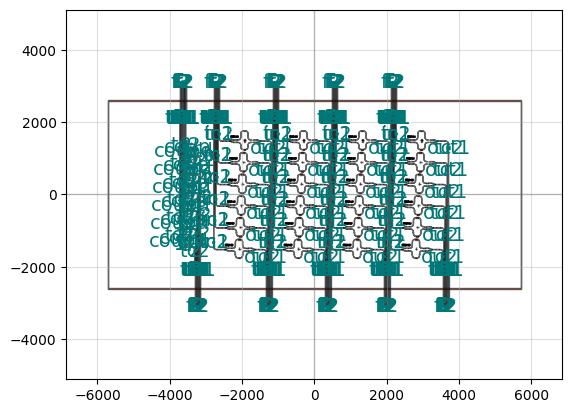

In [76]:
# Get the bounding box of the device
bbox = D.bbox

# Calculate the width and length of the device
chip_sizex = bbox[1][0] - bbox[0][0]  # x2 - x1
chip_sizey = bbox[1][1] - bbox[0][1] - 1000  # y2 - y1

# Print the size of the device
print(f"Device width: {chip_sizex}")
print(f"Device length: {chip_sizey}")

#Deep etching mask
Etchwidth=10
Rec = Device()
Detchmask1= Rec.add_ref(pg.rectangle(size = (chip_sizex-Etchwidth + 4000, chip_sizey-Etchwidth), layer = layer_Detch))
Detchmask2 = D.add_ref(pg.outline(Rec, distance = Etchwidth, precision = 1e-6, layer = layer_Detch))
Detchmask2.center=[0,0]

qp(D)

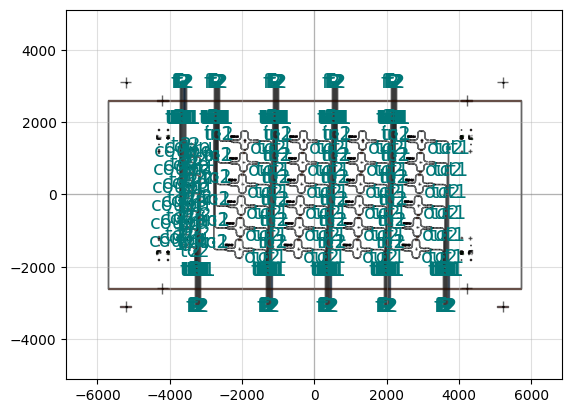

In [77]:
#EBL markers

marker1_x = chip_sizex/2 + 600
marker1_y = chip_sizey/2 - 800

marker_dice_x = chip_sizex/2-2000
marker_dice_y = chip_sizey/2-dev_pitch_y

marker2_x = marker1_x - 250
marker2_y = marker1_y - 200

marker3_y = marker2_y - 200
marker4_y = marker3_y - 200
marker5_y = marker1_y + 200



D13 = Device()

D13.add_ref(marker_dice_array(marker_x = (chip_sizex+1000)/2, marker_y = chip_sizey/2, layer = layer_marker)) #on edges
D13.add_ref(marker_dice_array(marker_x = chip_sizex/2+1500, marker_y = chip_sizey/2+500, layer = layer_marker))
D.add_ref(D13)

D12 = Device()

D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker1_y,arm_length = 10, arm_width = 20, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker2_x, marker_y = marker1_y,arm_length = 5, arm_width = 10, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker3_y,arm_length = 10, arm_width = 20, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker2_x, marker_y = marker3_y,arm_length = 5, arm_width = 10, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker4_y,arm_length = 50, arm_width = 5, layer = layer_marker))
D12.add_ref(inv_marker1_array(marker_x = marker2_x, marker_y = marker4_y,arm_length = 10, arm_width = 2, layer = layer_marker))
D12.add_ref(calipermarker_array(marker_x = marker1_x, marker_y = marker2_y, arm_length = 50, arm_width=2, num_notches=7, layer1= layer_marker, layer2=layer_test))
D12.add_ref(DLalignmarker_array(marker_x = marker2_x, marker_y = marker2_y, arm_length = 40, layer1= layer_marker, layer2=layer_test))

D.add_ref(D12)

qp(D)

In [78]:
# device name
dev_name = 'small_111224'

file_name = dev_name +'.gds'
label_dev = D.add_ref(pg.text(file_name, size = 150, justify = 'center', layer = layer_label))
label_dev.rotate(-90)
label_dev.center = [chip_sizex/2+1000,0]

D.flatten()
pattern_area = D.area()*10**-6 # unit mm^2

D.write_gds(file_name,
             unit = 1e-6, precision = 1e-10)
print('GDS saved')
print('pattern area = %.3f mm^2' % pattern_area)
print('GDS saved')

GDS saved
pattern area = 1.185 mm^2
GDS saved


/Users/kamilakunes/Desktop/MJLab/Phase Change Modulator/ModCAD/.venv/lib/python3.10/site-packages/phidl/device_layout.py:1555: UserWarning: [GDSPY] Polygons with more than 8190 are not supported by the official GDSII specification.  This GDSII file might not be compatible with all readers.
  lib.write_gds(filename, cells=all_cells)
